In [1]:
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import random
import sys
from tqdm import tqdm

import viz_2d as viz
import acd
import dset

# %%
import torch.nn as nn
import torch.nn.functional as F

In [2]:
model_type = 'mnist'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class AcdExp:
    def __init__(self, image = None, sweep_dim=1):
       self.image = image
       self.sweep_dim = sweep_dim

    def get_diff_scores(self, im_torch, im_orig, label_num, model, preds, sweep_dim):
        '''Computes different attribution scores
        '''
        scores = []

        # cd
        method = 'cd'
        tiles = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        scores_cd = acd.get_scores_2d(model, method=method, ims=tiles, 
                                    im_torch=im_torch, model_type=model_type, device=device)
        scores.append(scores_cd)
        for method in ['occlusion', 'build_up']: # 'build_up'
            tiles_break = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
            preds_break = acd.get_scores_2d(model, method=method, ims=tiles_break, 
                                                im_torch=im_torch, pred_ims=dset.pred_ims)
            if method == 'occlusion':
                preds_break += preds
            scores.append(np.copy(preds_break))
        
        # get integrated gradients scores
        scores.append(acd.ig_scores_2d(model, im_torch, num_classes=10, 
                                            im_size=28, sweep_dim=sweep_dim, ind=[label_num], device=device))
        return scores

    def get_explanation(self, model, img_ID):

        im_torch, im_orig, label_num = dset.get_im_and_label(img_ID, device=device) # this will download the mnist dataset
        preds = dset.pred_ims(model, im_orig, device=device).flatten()
        ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
        ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
        scores = self.get_diff_scores(im_torch, im_orig, label_num, model, preds, self.sweep_dim)

        return scores[0]

            # # plot raw image
            # num_rows = len(im_nums)
            # num_cols = len(scores) + 1
            # plt.subplot(num_rows, num_cols, 1 + x * num_cols)
            # plt.imshow(im_orig, cmap='gray')
            # plt.gca().xaxis.set_visible(False)
            # plt.yticks([])
            # if x == 0:
            #     plt.title('Image', fontsize=16)


            # # plot scores
            # vmax = max([np.max(scores[i]) for i in range(len(scores))])
            # vmin = min([np.min(scores[i]) for i in range(len(scores))])
            # vabs = max(abs(vmax), abs(vmin))
            # for i, tit in enumerate(['CD', 'Occlusion', 'Build-Up', 'IG']):
            #     plt.subplot(num_rows, num_cols, 2 + i + x * num_cols)
            #     if i == 0:
            #         plt.ylabel('pred: ' + str(ind[0]) + '...', fontsize=15)
            #     if x == 0:
            #         plt.title(tit, fontsize=16)
            #     p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
            #     plt.xticks([])
            #     plt.yticks([])
            #     divider = make_axes_locatable(plt.gca())
            #     cax = divider.append_axes("right", size="2%", pad=0.05)
            #     plt.colorbar(p, cax=cax)

# Model

In [5]:
class Net(nn.Module):
    '''A simple conv net
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def logits(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

    def predicted_class(self, x):
        pred = self.forward(x)
        _, pred = pred[0].max(0)
        return pred.item() #data[0]

# load the dataset

In [6]:
im_torch, im_orig, label = dset.get_im_and_label(250, device=device) # this will download the mnist dataset

# load the model

In [7]:
model = Net().to(device)
model.load_state_dict(torch.load('./mnist.model', map_location=device))
model = model.eval()

In [8]:
ACDexp = AcdExp(im_orig, sweep_dim=1)
score = ACDexp.get_explanation(model, 0)

/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/acd/scores/score_funcs.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(model(input_vecs))[:, class_to_explain]


In [9]:
score = score.reshape(28,28,10)
print(score.shape)

(28, 28, 10)


In [10]:
score = np.moveaxis(score, -1, 0)
score.shape

(10, 28, 28)

In [11]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for j in np.linspace(1, 0, 100):
    colors.append((30./255, 136./255, 229./255,j))
for j in np.linspace(0, 1, 100):
    colors.append((255./255, 13./255, 87./255,j))
red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

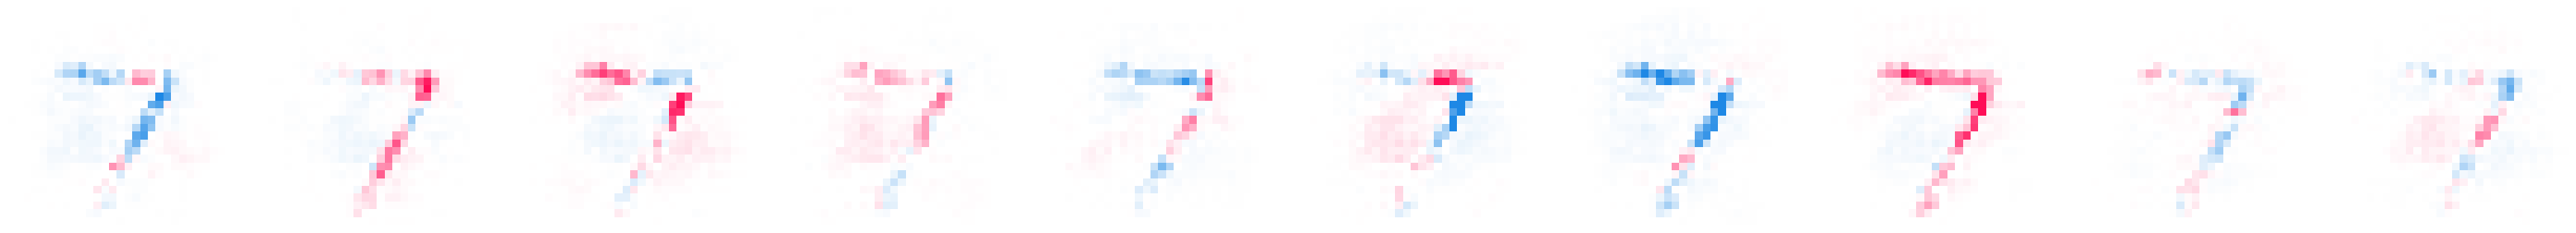

In [12]:
plt.figure(figsize=(40, 10))

for i in range(10):
    plt.subplot(1, 10, i+1)
    # plt.imshow(-bhem_exp.image, cmap='gray', alpha=0.3)
    plt.imshow(score[i], cmap=red_transparent_blue, vmin=-np.nanpercentile(score, 99.9),vmax=np.nanpercentile(score, 99.9))
    plt.axis('off')

plt.show()

# Score Function

In [6]:
def get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim):
    '''Computes different attribution scores
    '''
    scores = []

    # cd
    method = 'cd'
    tiles = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
    scores_cd = acd.get_scores_2d(model, method=method, ims=tiles, 
                                   im_torch=im_torch, model_type=model_type, device=device)
    scores.append(scores_cd)
    for method in ['occlusion', 'build_up']: # 'build_up'
        tiles_break = acd.tiling_2d.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        preds_break = acd.get_scores_2d(model, method=method, ims=tiles_break, 
                                            im_torch=im_torch, pred_ims=dset.pred_ims)
        if method == 'occlusion':
            preds_break += preds
        scores.append(np.copy(preds_break))
    
    # get integrated gradients scores
    scores.append(acd.ig_scores_2d(model, im_torch, num_classes=10, 
                                           im_size=28, sweep_dim=sweep_dim, ind=[label_num], device=device))
    return scores

# pick an image + get scores

In [7]:
im_nums = [34, 20, 36, 32] # 34: screen, 20: snake, 36: trash can, 32: crane

In [8]:
sweep_dim = 1

0it [00:00, ?it/s]/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/acd/scores/score_funcs.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(model(input_vecs))[:, class_to_explain]
4it [00:09,  2.28s/it]


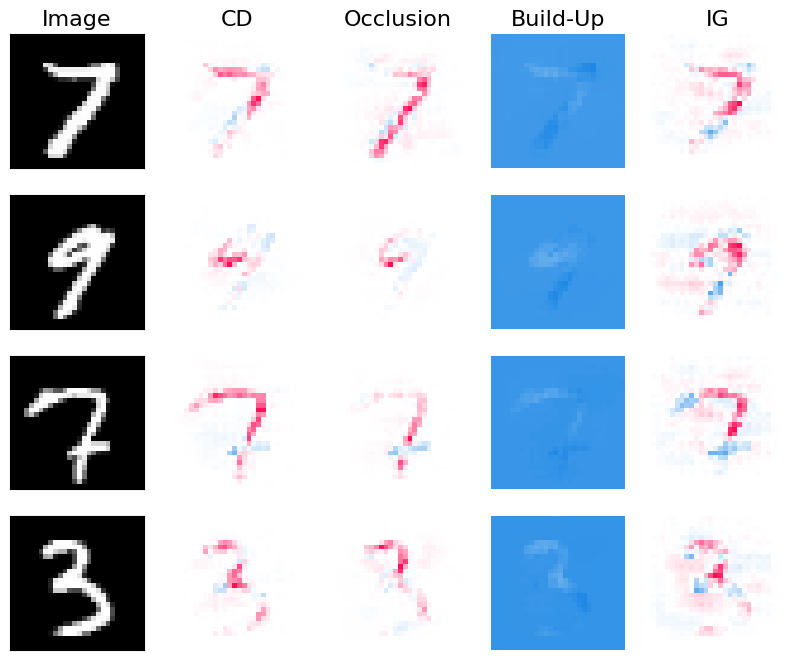

In [9]:
fig = plt.figure(figsize=(10, 8), facecolor='white')

for x, im_num in tqdm(enumerate(im_nums)):

    im_torch, im_orig, label_num = dset.get_im_and_label(im_num, device=device) # this will download the mnist dataset
    preds = dset.pred_ims(model, im_orig, device=device).flatten()
    ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
    ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
    scores = get_diff_scores(im_torch, im_orig, label_num, model, preds, sweep_dim)

    # plot raw image
    num_rows = len(im_nums)
    num_cols = len(scores) + 1
    plt.subplot(num_rows, num_cols, 1 + x * num_cols)
    plt.imshow(im_orig, cmap='gray')
    plt.gca().xaxis.set_visible(False)
    plt.yticks([])
    if x == 0:
        plt.title('Image', fontsize=16)


    # plot scores
    vmax = max([np.max(scores[i]) for i in range(len(scores))])
    vmin = min([np.min(scores[i]) for i in range(len(scores))])
    vabs = max(abs(vmax), abs(vmin))
    for i, tit in enumerate(['CD', 'Occlusion', 'Build-Up', 'IG']):
        plt.subplot(num_rows, num_cols, 2 + i + x * num_cols)
        if i == 0:
            plt.ylabel('pred: ' + str(ind[0]) + '...', fontsize=15)
        if x == 0:
            plt.title(tit, fontsize=16)
        p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
        plt.xticks([])
        plt.yticks([])
#     divider = make_axes_locatable(plt.gca())
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     plt.colorbar(p, cax=cax)

In [10]:
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
im_nums

[34, 20, 36, 32]

In [16]:
scores[0].shape

(784, 10)